In [1]:
import numpy as np
from model_vanilla_rot2d import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt
import os

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
file_name = 'rot2d_NoAug_argminW_alphamax20_lr0.0002'
out_dir_path = '/data/scratch/jahanian/mnist_dcgantf_bkup/out_old'
checkpoint_dir = os.path.join(out_dir_path,file_name,'checkpoint' )
sample_dir = os.path.join(out_dir_path,file_name,'sample' )
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_integer("alpha_max", 20, "max of alpha for steering")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

rot2d aug is disabled
loading mnist without augmenting ...
model_vanilla_rot2d ...
 [*] Reading checkpoints... /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/rot2d_NoAug_argminW_alphamax20_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from /data/scratch/jahanian/mnist_dcgantf_bkup/out_old/rot2d_NoAug_argminW_alphamax20_lr0.0002/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


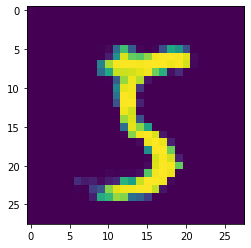

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    target_fn = np.copy(outputs_zs)
    mask_fn = np.ones(outputs_zs.shape)
#     print('rotate with alphas:', alpha)
    mask_out = np.zeros(outputs_zs.shape)

    for i in range(outputs_zs.shape[0]):
        if alpha!=0:
            M = cv2.getRotationMatrix2D((img_size//2, img_size//2), alpha, 1)
            target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
            mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)
        else:
            mask_out[i,:,:,:] = mask_fn[i,:,:,:]

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)

    if show_img:
        print('Target image:')
        imshow(imgrid(np.uint8(target_fn*255), cols=4))

    if show_mask:
        print('Target mask:')
        imshow(imgrid(np.uint8(mask_out*255), cols=4))

    return target_fn, mask_out


In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/rot2d_aug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 21)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-22 16:58:40,961 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.2065269947052002, 0, 0, 0.12206157296895981, 3
2019-09-22 16:58:40,971 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008020162582397461, 0, 10, 0.1433711051940918, -14
2019-09-22 16:58:40,981 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00854945182800293, 0, 20, 0.16030119359493256, 8
2019-09-22 16:58:40,992 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009823322296142578, 0, 30, 0.1872374266386032, -16
2019-09-22 16:58:41,003 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010347843170166016, 0, 40, 0.1673259437084198, -11
2019-09-22 16:58:41,014 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00997304916381836, 0, 50, 0.12492571771144867, -5
2019-09-22 16:58:41,025 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009545564651489258, 0, 60, 0.12923115491867065, -5
2019-09-22 16:58:41,036 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009547710418701172, 0, 70, 0.11421796679496765, 3
2019-09-22 16:58:41,047 [MainThr

2019-09-22 16:58:41,682 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00955510139465332, 0, 670, 0.11746028065681458, 14
2019-09-22 16:58:41,693 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009476184844970703, 0, 680, 0.13364383578300476, 20
2019-09-22 16:58:41,704 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009785652160644531, 0, 690, 0.14029672741889954, -15
2019-09-22 16:58:41,718 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012269973754882812, 0, 700, 0.1350678950548172, 19
2019-09-22 16:58:41,728 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009313583374023438, 0, 710, 0.12677760422229767, -7
2019-09-22 16:58:41,740 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009943723678588867, 0, 720, 0.1044485867023468, -9
2019-09-22 16:58:41,750 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009021282196044922, 0, 730, 0.14970369637012482, -18
2019-09-22 16:58:41,760 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009311914443969727, 0, 740, 0.1253846138715744, 14
2019-09-22 16:58:4

2019-09-22 16:58:42,398 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009258747100830078, 0, 1340, 0.12078215926885605, 9
2019-09-22 16:58:42,409 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009266853332519531, 0, 1350, 0.15480123460292816, -18
2019-09-22 16:58:42,419 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009402990341186523, 0, 1360, 0.046817999333143234, 1
2019-09-22 16:58:42,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009706735610961914, 0, 1370, 0.13087910413742065, -14
2019-09-22 16:58:42,441 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009425878524780273, 0, 1380, 0.15768133103847504, 20
2019-09-22 16:58:42,451 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009430408477783203, 0, 1390, 0.1359269618988037, -19
2019-09-22 16:58:42,462 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009412765502929688, 0, 1400, 0.12365089356899261, 13
2019-09-22 16:58:42,472 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00914764404296875, 0, 1410, 0.12923496961593628, -6
2019-09-

Loss: [0.013309004049748182, 0.01175674781575799]
2019-09-22 16:58:43,156 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009260177612304688, 0, 2010, 0.11858764290809631, 10
2019-09-22 16:58:43,167 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00982809066772461, 0, 2020, 0.11499277502298355, -11
2019-09-22 16:58:43,178 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009956598281860352, 0, 2030, 0.08621200919151306, 3
2019-09-22 16:58:43,190 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010225057601928711, 0, 2040, 0.09154178947210312, -5
2019-09-22 16:58:43,200 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009264707565307617, 0, 2050, 0.09444735944271088, 5
2019-09-22 16:58:43,210 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009181737899780273, 0, 2060, 0.15124700963497162, -15
2019-09-22 16:58:43,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008882522583007812, 0, 2070, 0.116524338722229, 6
2019-09-22 16:58:43,231 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009379386901855

2019-09-22 16:58:43,860 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009680509567260742, 0, 2670, 0.14109684526920319, -14
2019-09-22 16:58:43,871 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009075164794921875, 0, 2680, 0.13034021854400635, -15
2019-09-22 16:58:43,881 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009507179260253906, 0, 2690, 0.11152581125497818, -10
2019-09-22 16:58:43,892 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009362459182739258, 0, 2700, 0.019941186532378197, 1
2019-09-22 16:58:43,902 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00939798355102539, 0, 2710, 0.10870882868766785, -7
2019-09-22 16:58:43,913 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009164571762084961, 0, 2720, 0.14479081332683563, -16
2019-09-22 16:58:43,923 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00924825668334961, 0, 2730, 0.15106360614299774, -17
2019-09-22 16:58:43,933 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009383678436279297, 0, 2740, 0.10699226707220078, 9
2019-0

2019-09-22 16:58:44,552 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00975179672241211, 0, 3330, 0.07674803584814072, 5
2019-09-22 16:58:44,562 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009038686752319336, 0, 3340, 0.0641237199306488, 3
2019-09-22 16:58:44,573 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009261846542358398, 0, 3350, 0.05458187684416771, -3
2019-09-22 16:58:44,583 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009580373764038086, 0, 3360, 0.11812029778957367, -10
2019-09-22 16:58:44,598 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01395726203918457, 0, 3370, 0.12461312860250473, -16
2019-09-22 16:58:44,609 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009450435638427734, 0, 3380, 0.122769296169281, -15
2019-09-22 16:58:44,620 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009729623794555664, 0, 3390, 0.11729048937559128, -13
2019-09-22 16:58:44,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00975489616394043, 0, 3400, 0.10998022556304932, 17
2019-09-22 1

2019-09-22 16:58:45,261 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009563684463500977, 0, 4000, 0.07778561860322952, 4
Loss: [0.013309004049748182, 0.01175674781575799, 0.010875620357692241, 0.010045319000259042]
2019-09-22 16:58:45,272 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010062217712402344, 0, 4010, 0.07374337315559387, 5
2019-09-22 16:58:45,283 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009337186813354492, 0, 4020, 0.1003977358341217, 13
2019-09-22 16:58:45,293 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009299278259277344, 0, 4030, 0.12701091170310974, 19
2019-09-22 16:58:45,304 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009307384490966797, 0, 4040, 0.08924335986375809, -8
2019-09-22 16:58:45,314 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009443521499633789, 0, 4050, 0.12280326336622238, -19
2019-09-22 16:58:45,324 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009323835372924805, 0, 4060, 0.08673659712076187, -6
2019-09-22 16:58:45,335 [MainThread  ] [

2019-09-22 16:58:45,956 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008862733840942383, 0, 4660, 0.09191659092903137, 19
2019-09-22 16:58:45,966 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00915980339050293, 0, 4670, 0.10378296673297882, 15
2019-09-22 16:58:45,976 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00892782211303711, 0, 4680, 0.010261408984661102, 1
2019-09-22 16:58:45,987 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009409189224243164, 0, 4690, 0.11684215813875198, 17
2019-09-22 16:58:45,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00900125503540039, 0, 4700, 0.11530803143978119, -16
2019-09-22 16:58:46,007 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00923466682434082, 0, 4710, 0.047683678567409515, 2
2019-09-22 16:58:46,018 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009787797927856445, 0, 4720, 0.09798438102006912, 8
2019-09-22 16:58:46,029 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009145498275756836, 0, 4730, 0.09125527739524841, 6
2019-09-22 16

2019-09-22 16:58:46,673 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00938272476196289, 0, 5320, 0.10616730153560638, 13
2019-09-22 16:58:46,684 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009359121322631836, 0, 5330, 0.042076028883457184, 2
2019-09-22 16:58:46,695 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009722471237182617, 0, 5340, 0.09982489794492722, -12
2019-09-22 16:58:46,705 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008898258209228516, 0, 5350, 0.07491270452737808, -7
2019-09-22 16:58:46,715 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009729385375976562, 0, 5360, 0.11994532495737076, -18
2019-09-22 16:58:46,726 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00920867919921875, 0, 5370, 0.013193296268582344, -1
2019-09-22 16:58:46,736 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009080171585083008, 0, 5380, 0.009944524616003036, -1
2019-09-22 16:58:46,746 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009376049041748047, 0, 5390, 0.08889283984899521, 10
2019-0

2019-09-22 16:58:47,375 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009138107299804688, 0, 5990, 0.11480795592069626, 16
2019-09-22 16:58:47,385 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008957386016845703, 0, 6000, 0.12745589017868042, -13
Loss: [0.013309004049748182, 0.01175674781575799, 0.010875620357692241, 0.010045319000259042, 0.009336769727058708, 0.009021104958839714]
2019-09-22 16:58:47,395 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009412765502929688, 0, 6010, 0.10798979550600052, -13
2019-09-22 16:58:47,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009141683578491211, 0, 6020, 0.09320349246263504, -9
2019-09-22 16:58:47,416 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009041786193847656, 0, 6030, 0.09793157130479813, 14
2019-09-22 16:58:47,426 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008886337280273438, 0, 6040, 0.11394494771957397, -14
2019-09-22 16:58:47,437 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009398460388183594, 0, 6050, 0.1146980449557

2019-09-22 16:58:48,066 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008833885192871094, 0, 6650, 0.10298837721347809, 16
2019-09-22 16:58:48,076 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008880615234375, 0, 6660, 0.10344462096691132, -11
2019-09-22 16:58:48,087 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009377241134643555, 0, 6670, 0.09568782150745392, -11
2019-09-22 16:58:48,097 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008652448654174805, 0, 6680, 0.006139754317700863, 1
2019-09-22 16:58:48,108 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008984088897705078, 0, 6690, 0.08920267224311829, -11
2019-09-22 16:58:48,118 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009253740310668945, 0, 6700, 0.024013901129364967, -2
2019-09-22 16:58:48,127 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00799417495727539, 0, 6710, 0.007957546971738338, 1
2019-09-22 16:58:48,136 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008006095886230469, 0, 6720, 0.0901443213224411, 7
2019-09-22

2019-09-22 16:58:48,739 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009301185607910156, 0, 7300, 0.10989052057266235, 18
2019-09-22 16:58:48,749 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009470939636230469, 0, 7310, 0.09391604363918304, 15
2019-09-22 16:58:48,760 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009403228759765625, 0, 7320, 0.10921705514192581, 17
2019-09-22 16:58:48,770 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00911569595336914, 0, 7330, 0.09106414765119553, 11
2019-09-22 16:58:48,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009042024612426758, 0, 7340, 0.1073366180062294, -10
2019-09-22 16:58:48,791 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009627580642700195, 0, 7350, 0.06801671534776688, 5
2019-09-22 16:58:48,801 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00959324836730957, 0, 7360, 0.10926064848899841, 14
2019-09-22 16:58:48,811 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009130239486694336, 0, 7370, 0.0677642673254013, -5
2019-09-22 1

2019-09-22 16:58:49,391 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010135650634765625, 0, 7970, 0.07444272935390472, 7
2019-09-22 16:58:49,402 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01014399528503418, 0, 7980, 0.11124442517757416, -12
2019-09-22 16:58:49,414 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01025843620300293, 0, 7990, 0.10662925243377686, 13
2019-09-22 16:58:49,425 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009850740432739258, 0, 8000, 0.08794274181127548, -11
Loss: [0.013309004049748182, 0.01175674781575799, 0.010875620357692241, 0.010045319000259042, 0.009336769727058708, 0.009021104958839714, 0.008445364314131438, 0.008765702603384853]
2019-09-22 16:58:49,437 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009729146957397461, 0, 8010, 0.03886644169688225, -4
2019-09-22 16:58:49,448 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00969696044921875, 0, 8020, 0.09101763367652893, -10
2019-09-22 16:58:49,459 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0096

2019-09-22 16:58:50,124 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010234832763671875, 0, 8620, 0.08462469279766083, -10
2019-09-22 16:58:50,133 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007539510726928711, 0, 8630, 0.09253274649381638, -14
2019-09-22 16:58:50,141 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007093191146850586, 0, 8640, 0.09032342582941055, -13
2019-09-22 16:58:50,149 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007241725921630859, 0, 8650, 0.1184830293059349, 16
2019-09-22 16:58:50,158 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008306026458740234, 0, 8660, 0.0825076699256897, -10
2019-09-22 16:58:50,169 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008733510971069336, 0, 8670, 0.030995894223451614, 3
2019-09-22 16:58:50,179 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009422063827514648, 0, 8680, 0.042936861515045166, 4
2019-09-22 16:58:50,190 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00912165641784668, 0, 8690, 0.086714968085289, -10
2019-09-

2019-09-22 16:58:50,816 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009816646575927734, 0, 9270, 0.08298394829034805, -7
2019-09-22 16:58:50,827 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009433269500732422, 0, 9280, 0.006677079014480114, -1
2019-09-22 16:58:50,838 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00920248031616211, 0, 9290, 0.015835881233215332, -2
2019-09-22 16:58:50,848 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009511947631835938, 0, 9300, 0.10376972705125809, 9
2019-09-22 16:58:50,860 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010225534439086914, 0, 9310, 0.08864035457372665, -15
2019-09-22 16:58:50,871 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009415626525878906, 0, 9320, 0.05863143503665924, 5
2019-09-22 16:58:50,881 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009545564651489258, 0, 9330, 0.08062765747308731, 8
2019-09-22 16:58:50,892 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009364128112792969, 0, 9340, 0.07909794896841049, -9
2019-09-2

2019-09-22 16:58:51,543 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010838031768798828, 0, 9940, 0.1066841334104538, 13
2019-09-22 16:58:51,554 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010178327560424805, 0, 9950, 0.0924353078007698, 12
2019-09-22 16:58:51,566 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010505914688110352, 0, 9960, 0.00496656633913517, -1
2019-09-22 16:58:51,577 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01010274887084961, 0, 9970, 0.1286344826221466, -15
2019-09-22 16:58:51,588 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00964045524597168, 0, 9980, 0.10575597733259201, -13
2019-09-22 16:58:51,599 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010066509246826172, 0, 9990, 0.0922907367348671, -15
2019-09-22 16:58:51,610 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009958267211914062, 0, 10000, 0.07195538282394409, 9
Loss: [0.013309004049748182, 0.01175674781575799, 0.010875620357692241, 0.010045319000259042, 0.009336769727058708, 0.00902110495883971

2019-09-22 16:58:52,256 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009686946868896484, 0, 10580, 0.10902578383684158, -18
2019-09-22 16:58:52,267 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010093212127685547, 0, 10590, 0.02393123134970665, -3
2019-09-22 16:58:52,278 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00918722152709961, 0, 10600, 0.12080938369035721, 13
2019-09-22 16:58:52,288 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00916743278503418, 0, 10610, 0.0650181770324707, 9
2019-09-22 16:58:52,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009338140487670898, 0, 10620, 0.0796409398317337, 11
2019-09-22 16:58:52,309 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009876728057861328, 0, 10630, 0.09042130410671234, 12
2019-09-22 16:58:52,320 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009334564208984375, 0, 10640, 0.08071126788854599, 10
2019-09-22 16:58:52,330 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009385824203491211, 0, 10650, 0.10820344090461731, 16
2019

2019-09-22 16:58:52,981 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010404586791992188, 0, 11220, 0.07671280205249786, -10
2019-09-22 16:58:52,992 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010303258895874023, 0, 11230, 0.062074385583400726, 7
2019-09-22 16:58:53,004 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010282039642333984, 0, 11240, 0.07698436081409454, 10
2019-09-22 16:58:53,015 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010381460189819336, 0, 11250, 0.12144085019826889, -19
2019-09-22 16:58:53,026 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010337114334106445, 0, 11260, 0.09131800383329391, -13
2019-09-22 16:58:53,038 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01040029525756836, 0, 11270, 0.03564608842134476, -5
2019-09-22 16:58:53,049 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010241031646728516, 0, 11280, 0.09576838463544846, -12
2019-09-22 16:58:53,060 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010069608688354492, 0, 11290, 0.05179451406002045, 

2019-09-22 16:58:53,721 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009492874145507812, 0, 11880, 0.09465787559747696, 16
2019-09-22 16:58:53,732 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00959467887878418, 0, 11890, 0.04473864659667015, -6
2019-09-22 16:58:53,742 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009727954864501953, 0, 11900, 0.07895957678556442, -11
2019-09-22 16:58:53,753 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009388208389282227, 0, 11910, 0.09301313757896423, 15
2019-09-22 16:58:53,763 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009338855743408203, 0, 11920, 0.08462244272232056, 13
2019-09-22 16:58:53,775 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010235071182250977, 0, 11930, 0.046580683439970016, -7
2019-09-22 16:58:53,786 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009752750396728516, 0, 11940, 0.0254980456084013, -5
2019-09-22 16:58:53,797 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010076284408569336, 0, 11950, 0.024111904203891754, 4


2019-09-22 16:58:54,393 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009453773498535156, 0, 12520, 0.03763454034924507, -5
2019-09-22 16:58:54,404 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009089231491088867, 0, 12530, 0.06634131819009781, -8
2019-09-22 16:58:54,414 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009151697158813477, 0, 12540, 0.07890033721923828, 14
2019-09-22 16:58:54,424 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008829116821289062, 0, 12550, 0.09486399590969086, -14
2019-09-22 16:58:54,433 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00900411605834961, 0, 12560, 0.06951731443405151, -10
2019-09-22 16:58:54,444 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009191274642944336, 0, 12570, 0.06789465993642807, 8
2019-09-22 16:58:54,454 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009124994277954102, 0, 12580, 0.10664939880371094, 19
2019-09-22 16:58:54,463 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008960485458374023, 0, 12590, 0.06274407356977463, 12


2019-09-22 16:58:55,071 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011333703994750977, 0, 13160, 0.07409236580133438, -12
2019-09-22 16:58:55,083 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010523796081542969, 0, 13170, 0.10958743095397949, 16
2019-09-22 16:58:55,093 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009325981140136719, 0, 13180, 0.024387070909142494, 4
2019-09-22 16:58:55,102 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008066654205322266, 0, 13190, 0.05251677706837654, -7
2019-09-22 16:58:55,110 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007202625274658203, 0, 13200, 0.018119029700756073, -4
2019-09-22 16:58:55,119 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007843971252441406, 0, 13210, 0.06571642309427261, -9
2019-09-22 16:58:55,130 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00948476791381836, 0, 13220, 0.01129776518791914, 3
2019-09-22 16:58:55,140 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009366035461425781, 0, 13230, 0.0799979642033577, -12


2019-09-22 16:58:55,765 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010079622268676758, 0, 13820, 0.0068938471376895905, 2
2019-09-22 16:58:55,775 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00927114486694336, 0, 13830, 0.015942536294460297, -4
2019-09-22 16:58:55,785 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009199380874633789, 0, 13840, 0.002048792550340295, 1
2019-09-22 16:58:55,796 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009187698364257812, 0, 13850, 0.09315307438373566, -20
2019-09-22 16:58:55,806 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00891566276550293, 0, 13860, 0.058298733085393906, -12
2019-09-22 16:58:55,816 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009568452835083008, 0, 13870, 0.015875425189733505, 4
2019-09-22 16:58:55,827 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009465217590332031, 0, 13880, 0.043409980833530426, 9
2019-09-22 16:58:55,838 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009897947311401367, 0, 13890, 0.10027828812599182, 

2019-09-22 16:58:56,428 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009314775466918945, 0, 14450, 0.028675833716988564, -6
2019-09-22 16:58:56,441 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011692285537719727, 0, 14460, 0.07524728775024414, -17
2019-09-22 16:58:56,452 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009632110595703125, 0, 14470, 0.004021347966045141, -2
2019-09-22 16:58:56,462 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00950002670288086, 0, 14480, 0.07339353114366531, -14
2019-09-22 16:58:56,473 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009158849716186523, 0, 14490, 0.07401780039072037, -15
2019-09-22 16:58:56,484 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009884119033813477, 0, 14500, 0.055591512471437454, 12
2019-09-22 16:58:56,494 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009833097457885742, 0, 14510, 0.03730239346623421, -7
2019-09-22 16:58:56,505 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009732961654663086, 0, 14520, 0.00824133399873972

2019-09-22 16:58:57,128 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010123014450073242, 0, 15080, 0.06686261296272278, 12
2019-09-22 16:58:57,144 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011458635330200195, 0, 15090, 0.025052808225154877, 5
2019-09-22 16:58:57,156 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01011037826538086, 0, 15100, 0.03460653871297836, -9
2019-09-22 16:58:57,168 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01090693473815918, 0, 15110, 0.008405162021517754, -3
2019-09-22 16:58:57,179 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009694099426269531, 0, 15120, 0.012575067579746246, 5
2019-09-22 16:58:57,190 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010454654693603516, 0, 15130, 0.004865134600549936, -2
2019-09-22 16:58:57,202 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01024174690246582, 0, 15140, 0.019672781229019165, 5
2019-09-22 16:58:57,214 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010715007781982422, 0, 15150, 0.01268082670867443, -4
2

2019-09-22 16:58:57,886 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009675264358520508, 0, 15740, 0.003985775634646416, 2
2019-09-22 16:58:57,897 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009458780288696289, 0, 15750, 0.04059611260890961, 7
2019-09-22 16:58:57,912 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.014092683792114258, 0, 15760, 0.09221910685300827, 15
2019-09-22 16:58:57,924 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009938240051269531, 0, 15770, 0.040877148509025574, -8
2019-09-22 16:58:57,940 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015537023544311523, 0, 15780, 0.062376607209444046, -12
2019-09-22 16:58:57,952 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00992131233215332, 0, 15790, 0.03636160120368004, -9
2019-09-22 16:58:57,963 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009714841842651367, 0, 15800, 0.032765574753284454, -7
2019-09-22 16:58:57,975 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010858297348022461, 0, 15810, 0.09414444863796234, -

2019-09-22 16:58:58,633 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010016441345214844, 0, 16370, 0.06944853812456131, -17
2019-09-22 16:58:58,643 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00902867317199707, 0, 16380, 0.023825671523809433, 7
2019-09-22 16:58:58,654 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009630918502807617, 0, 16390, 0.008991428650915623, 4
2019-09-22 16:58:58,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009773492813110352, 0, 16400, 0.06139172986149788, 13
2019-09-22 16:58:58,676 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009835243225097656, 0, 16410, 0.028993483632802963, -8
2019-09-22 16:58:58,686 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009511470794677734, 0, 16420, 0.06929907202720642, -16
2019-09-22 16:58:58,697 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009519815444946289, 0, 16430, 0.04757091403007507, -11
2019-09-22 16:58:58,708 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009557485580444336, 0, 16440, 0.05913453549146652, 

2019-09-22 16:58:59,331 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010051965713500977, 0, 17010, 0.04460529237985611, 16
2019-09-22 16:58:59,342 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010083913803100586, 0, 17020, 0.01835786923766136, 7
2019-09-22 16:58:59,359 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.015133142471313477, 0, 17030, 0.04537160322070122, -19
2019-09-22 16:58:59,370 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010271549224853516, 0, 17040, 0.032655153423547745, 10
2019-09-22 16:58:59,380 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009319543838500977, 0, 17050, 0.008550899103283882, 4
2019-09-22 16:58:59,391 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009460926055908203, 0, 17060, 0.02894461899995804, -11
2019-09-22 16:58:59,409 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.016077280044555664, 0, 17070, 0.03608864173293114, -13
2019-09-22 16:58:59,420 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010061264038085938, 0, 17080, 0.049762528389692307,

2019-09-22 16:59:00,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01047515869140625, 0, 17670, 0.05529867485165596, -18
2019-09-22 16:59:00,070 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010040283203125, 0, 17680, 0.011137706227600574, -5
2019-09-22 16:59:00,081 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009911298751831055, 0, 17690, 0.025661161169409752, 8
2019-09-22 16:59:00,092 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009979009628295898, 0, 17700, 0.06213676184415817, -19
2019-09-22 16:59:00,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009633302688598633, 0, 17710, 0.0008339833002537489, -1
2019-09-22 16:59:00,114 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009676694869995117, 0, 17720, 0.049739036709070206, -13
2019-09-22 16:59:00,124 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009592294692993164, 0, 17730, 0.042453914880752563, -13
2019-09-22 16:59:00,135 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010063648223876953, 0, 17740, 0.00281345797702670

2019-09-22 16:59:00,767 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00964212417602539, 0, 18300, 0.027976160869002342, -11
2019-09-22 16:59:00,778 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009706258773803711, 0, 18310, 0.04686947911977768, 13
2019-09-22 16:59:00,788 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00938272476196289, 0, 18320, 0.014960304833948612, -6
2019-09-22 16:59:00,798 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009197235107421875, 0, 18330, 0.021626757457852364, 8
2019-09-22 16:59:00,808 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008913516998291016, 0, 18340, 0.07261805981397629, 18
2019-09-22 16:59:00,822 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012644767761230469, 0, 18350, 0.005181857384741306, 3
2019-09-22 16:59:00,833 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009319543838500977, 0, 18360, 0.013902739621698856, -6
2019-09-22 16:59:00,843 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009026765823364258, 0, 18370, 0.0339384488761425, -1

2019-09-22 16:59:01,499 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009536027908325195, 0, 18960, 0.026621466502547264, -11
2019-09-22 16:59:01,510 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009830713272094727, 0, 18970, 0.0009815816301852465, 1
2019-09-22 16:59:01,521 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009934425354003906, 0, 18980, 0.014340651221573353, 6
2019-09-22 16:59:01,531 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009364128112792969, 0, 18990, 0.07491423189640045, 19
2019-09-22 16:59:01,542 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008994817733764648, 0, 19000, 0.00920933298766613, -4
Loss: [0.013309004049748182, 0.01175674781575799, 0.010875620357692241, 0.010045319000259042, 0.009336769727058708, 0.009021104958839714, 0.008445364314131438, 0.008765702603384853, 0.007813471985980869, 0.007735068647423759, 0.008065343717113137, 0.007286088218679651, 0.006740805281559005, 0.005195077325450256, 0.005090824317187071, 0.00474091600778047, 0.0036831481851

2019-09-22 16:59:02,161 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008970975875854492, 0, 19590, 0.0486261248588562, -15
2019-09-22 16:59:02,171 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009443521499633789, 0, 19600, 0.010722195729613304, 6
2019-09-22 16:59:02,182 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010035991668701172, 0, 19610, 0.06097211316227913, 18
2019-09-22 16:59:02,194 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009851932525634766, 0, 19620, 0.004198533948510885, 3
2019-09-22 16:59:02,205 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009902000427246094, 0, 19630, 0.04808664694428444, 16
2019-09-22 16:59:02,216 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010505437850952148, 0, 19640, 0.023028649389743805, 10
2019-09-22 16:59:02,228 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010400533676147461, 0, 19650, 0.01883508265018463, -7
2019-09-22 16:59:02,240 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010226964950561523, 0, 19660, 0.008813234977424145, 4

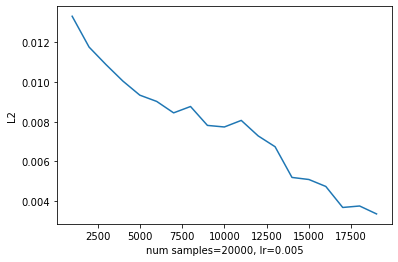

[0.013309004049748182, 0.01175674781575799, 0.010875620357692241, 0.010045319000259042, 0.009336769727058708, 0.009021104958839714, 0.008445364314131438, 0.008765702603384853, 0.007813471985980869, 0.007735068647423759, 0.008065343717113137, 0.007286088218679651, 0.006740805281559005, 0.005195077325450256, 0.005090824317187071, 0.00474091600778047, 0.003683148185198661, 0.0037570143694756553, 0.0033584567766520193]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[-30. -24. -18. -12.  -6.   0.   6.  12.  18.  24.  30.]


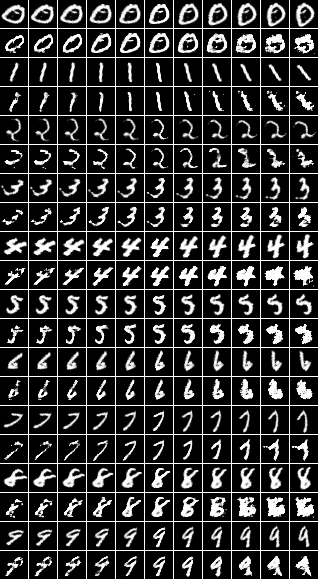

In [16]:
num_samples = 10

a = np.linspace(-30,30,11)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 10000
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained

# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
alphas = alphas_no_log
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, input_test)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -27.00, dist 0.01 +/- 0.01
alpha: -21.00, dist 0.02 +/- 0.01
alpha: -15.00, dist 0.02 +/- 0.01
alpha: -9.00, dist 0.02 +/- 0.01
alpha: -3.00, dist 0.03 +/- 0.01
alpha: 3.00, dist 0.03 +/- 0.01
alpha: 9.00, dist 0.02 +/- 0.01
alpha: 15.00, dist 0.02 +/- 0.01
alpha: 21.00, dist 0.02 +/- 0.01
alpha: 27.00, dist 0.01 +/- 0.01
2019-09-22 17:01:09,365 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-22 17:01:09,371 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


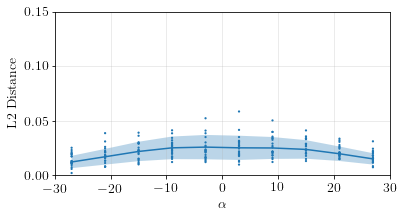

In [21]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/plots_rot2d'
savefile_transform_effect = file_name+'_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.15])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_transform_effect + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_transform_effect + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -30.00, dist 0.09 +/- 0.01
alpha: -24.00, dist 0.07 +/- 0.01
alpha: -18.00, dist 0.06 +/- 0.01
alpha: -12.00, dist 0.04 +/- 0.00
alpha: -6.00, dist 0.02 +/- 0.00
alpha: 0.00, dist 0.00 +/- 0.00
alpha: 6.00, dist 0.02 +/- 0.00
alpha: 12.00, dist 0.04 +/- 0.01
alpha: 18.00, dist 0.07 +/- 0.01
alpha: 24.00, dist 0.10 +/- 0.01
alpha: 30.00, dist 0.12 +/- 0.01


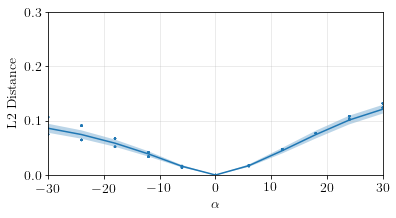

In [23]:
## plots and saves the computed similarity matrix
output_dir = './out/plots/plots_rot2d'
savefile_loss = file_name+'_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# ax.set_ylim([0, 0.8])
ax.set_ylim([0, 0.3])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile_loss + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile_loss + '.pdf'),
          bbox_inches="tight", pad_inches=0)

In [24]:
np.save(os.path.join(output_dir, savefile_transform_effect+'.npy'), dist_info)
np.save(os.path.join(output_dir, savefile_loss+'.npy'), dist_trained_info)